# Profiling and optimizing

Jelle, May 2019

This illustrates profiling, and optimizing using numba. We'll use the computation of the full width at half maximum (FWHM) as an example.

#### Boring setup code, don't read

In [17]:
import numpy as np
import straxen
import matplotlib
import matplotlib.pyplot as plt

# Get PMT positions from the XENON1T config
from ast import literal_eval
import configparser
config = configparser.ConfigParser()
config.read_string(
    straxen.get_resource('https://raw.githubusercontent.com/XENON1T/pax/master/pax/config/XENON1T.ini'))
pmt_positions = np.array([
    (q['position']['x'], q['position']['y'])
    for q in literal_eval(config['DEFAULT']['pmts'])])[:248]


## Load data

It's always a good idea to try your algorithm on a small piece of data first.

In [20]:
import strax
import straxen
st = straxen.contexts.strax_workshop_dali()

run_id = '180215_1029'
peaks = st.get_array(run_id, 'peaks'
                     #, seconds_range=(0, 20)
                    )
peaks.nbytes / 1e6

153.137644

## First attempt

In [21]:
def fwhm_1(peaks):
    result = np.zeros(len(peaks))
    
    for peak_i, p in enumerate(peaks):
        wv = p['data']
        half_max = wv.max() / 2
        if half_max <= 0:
            # Strange peak...
            continue

        start_i = 0
        end_i = 0
        for i, x in enumerate(wv):
            if x > half_max:
                if start_i == 0:
                    start_i = i
                end_i = i

        result[peak_i] = p['dt'] * (end_i - start_i)
        
    return result

In [23]:
%%time
result = fwhm_1(peaks)

CPU times: user 14.7 s, sys: 261 ms, total: 14.9 s
Wall time: 14.6 s


(1, 100000.0)

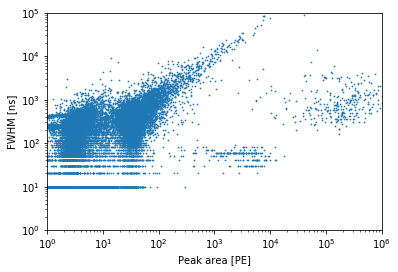

In [24]:
plt.scatter(peaks['area'],
            result, marker='.', s=2);
plt.xlabel("Peak area [PE]")
plt.ylabel("FWHM [ns]")
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 1e6)
plt.ylim(1, 1e5)

OK, so that took 10-15 seconds. Is that fast or slow? To test that, let's compare it against a complete strax reprocessing from raw_records.

Below we duplicate our current context, and replace the storage with just a readonly DataDirectory reading from the raw folder. This way, it will reprocess from raw records every time (and save nothing).

In [25]:
st2 = st.new_context()
st2.storage = [strax.DataDirectory('/dali/lgrandi/aalbers/strax_data_raw', 
                                   readonly=True)]

In [27]:
# %%prun -D my_output.prof
# 1 + 1

Normally you'd profile python code with the [prun cell magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-prun):

    %%prun -D my_output.prof
    
However, strax is a multithreaded application, which the profiler underneath this (cProfile) does not support. You can do it, but the output will not make a lot of sense (you'll see a lot of time lost in `acquiring thread.Lock()` etc.).

Instead, we use a different profiler (`yappi`), which we wrapped in a convenient function:

In [28]:
%%time
with strax.profile_threaded('5min_run.prof'):
    _ = st2.get_df(run_id, 'event_info',)

CPU times: user 33.1 s, sys: 24.9 s, total: 58 s
Wall time: 26.1 s


To visualize this, you can use [snakeviz](https://jiffyclub.github.io/snakeviz). Download the file `5min_run.prof` to your laptop and run `snakeviz 5min_run.prof`.

# Line profiling

The standard profile output is quite hard to read, and coarse-grained to the function level. This is great for profiling large applications like strax, but not for small algorithms like this.

In [29]:
%%prun
fwhm_1(peaks)

         195003 function calls in 14.526 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   14.201   14.201   14.525   14.525 <ipython-input-21-7db061ecab71>:1(fwhm_1)
    64999    0.285    0.000    0.285    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    64999    0.025    0.000    0.324    0.000 {method 'max' of 'numpy.ndarray' objects}
    64999    0.014    0.000    0.299    0.000 _methods.py:26(_amax)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        1    0.000    0.000   14.526   14.526 <string>:2(<module>)
        1    0.000    0.000   14.526   14.526 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

The `line_profiler` package allows much more detailed profiling.

In [30]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [31]:
%lprun -f fwhm_1 fwhm_1(peaks)

Timer unit: 1e-06 s

Total time: 21.3319 s
File: <ipython-input-21-7db061ecab71>
Function: fwhm_1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def fwhm_1(peaks):
     2         1        223.0    223.0      0.0      result = np.zeros(len(peaks))
     3                                               
     4     65000      33631.0      0.5      0.2      for peak_i, p in enumerate(peaks):
     5     64999      74348.0      1.1      0.3          wv = p['data']
     6     64999     645549.0      9.9      3.0          half_max = wv.max() / 2
     7     64999      50672.0      0.8      0.2          if half_max <= 0:
     8                                                       # Strange peak...
     9     26232       9318.0      0.4      0.0              continue
    10                                           
    11     38767      14450.0      0.4      0.1          start_i = 0
    12     38767      13906.0      0.4 

## Optimization with numpy

### Remove inner for loop

In [32]:
def fwhm_2(peaks):
    result = np.zeros(len(peaks))

    for peak_i, p in enumerate(peaks):
        wv = p['data']
        half_max = wv.max() / 2
        if half_max <= 0:
            # Strange peak...
            continue

        above_hm = np.where(wv > half_max)[0]
        result[peak_i] = p['dt'] * (above_hm.max() - above_hm.min())
        
    return result

In [36]:
%%timeit
result = fwhm_2(peaks)

873 ms ± 5.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%lprun -f fwhm_2 fwhm_2(peaks)

Timer unit: 1e-06 s

Total time: 1.1232 s
File: <ipython-input-32-ab22f492182b>
Function: fwhm_2 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def fwhm_2(peaks):
     2         1        221.0    221.0      0.0      result = np.zeros(len(peaks))
     3                                           
     4     65000      32824.0      0.5      2.9      for peak_i, p in enumerate(peaks):
     5     64999      70740.0      1.1      6.3          wv = p['data']
     6     64999     449956.0      6.9     40.1          half_max = wv.max() / 2
     7     64999      48627.0      0.7      4.3          if half_max <= 0:
     8                                                       # Strange peak...
     9     26232       8970.0      0.3      0.8              continue
    10                                           
    11     38767     138774.0      3.6     12.4          above_hm = np.where(wv > half_max)[0]
    12     38767  

By the way, never use np.append / np.concatenate to collect results in a loop!
```python
    for p in peak:
        ...
        result = np.append(result, ...)
```
This will cause the entire result array to be copied each iteration.

### more Numpy numpy optimization...

In [38]:
def fwhm_3(peaks):
    result = np.zeros(len(peaks))
    half_maxes = np.max(peaks['data'], axis=1) / 2

    for peak_i, p in enumerate(peaks):
        wv = p['data']
        half_max = half_maxes[peak_i]
        if half_max <= 0:
            # Strange peak...
            continue

        above_hm = np.where(wv > half_max)[0]
        result[peak_i] = p['dt'] * (above_hm[-1] - above_hm[0])
        
    return result

In [39]:
%%timeit
fwhm_3(peaks)

443 ms ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#%lprun -f fwhm_3 fwhm_3(peaks)

### Not exactly FWHM, but very fast:

In [ ]:
def above_max(peaks):
    result = np.zeros(len(peaks))
    
    half_max = peaks['data'].max(axis=1) / 2
    above_max = peaks['data'] > half_max[:, np.newaxis]

    return above_max.sum(axis=1)

In [ ]:
%%timeit
result = above_max(peaks)

### Enter numba

In [41]:
import numba

@numba.njit
def fwhm_2_numba(peaks):
    result = np.zeros(len(peaks))

    for peak_i, p in enumerate(peaks):
        wv = p['data']
        half_max = wv.max() / 2
        if half_max <= 0:
            # Strange peak...
            continue

        above_hm = np.where(wv > half_max)[0]
        result[peak_i] = p['dt'] * (above_hm.max() - above_hm.min())
        
    return result

In [43]:
%%time
fwhm_2_numba(peaks)

CPU times: user 53.4 ms, sys: 839 µs, total: 54.3 ms
Wall time: 54.3 ms


array([  0.,  60.,   0., ...,   0., 240.,   0.])

In [44]:
%%timeit
result = fwhm_2_numba(peaks)

44.5 ms ± 8.05 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


This is more than a factor 10 faster. But... we can also just take our very first implementation:

In [52]:
@numba.njit
def fwhm_1_numba(peaks):
    result = np.zeros(len(peaks))
    
    for peak_i, p in enumerate(peaks):
        wv = p['data']
        half_max = wv.max() / 2
        if half_max <= 0:
            # Strange peak...
            continue

        start_i = 0
        end_i = 0
        for i, x in enumerate(wv):
            if x > half_max:
                if start_i == 0:
                    start_i = i
                end_i = i

        result[peak_i] = p['dt'] * (end_i - start_i)
        
    return result

# This does the same without repeating the definition
# fwhm_1_numba = numba.njit(fwhm_1)

In [47]:
%%time
fwhm_1_numba(peaks)

CPU times: user 43.5 ms, sys: 0 ns, total: 43.5 ms
Wall time: 43.5 ms


array([  0.,  60.,   0., ...,   0., 240.,   0.])

In [48]:
%%timeit
result = fwhm_1_numba(peaks)

32.8 ms ± 33 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
